# DogFaceNet version 7: final version!
IT WORKS!!!

### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

In [2]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

3148


In [4]:
# Normalization
images /= 255.0


In [5]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

485


Open-set: test set

In [6]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

Triplet definition

In [7]:
def define_triplets(images,labels,nbof_triplet = 10000 * 3):
    triplet_train = np.empty((nbof_triplet,h,w,c))
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in tqdm_notebook(range(0,nbof_triplet,3)):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = images[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train[i] = keep_classAP[idx_image1]
        triplet_train[i+1] = keep_classAP[idx_image2]
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = images[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train[i+2] = keep_classN[idx_image3]
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet

In [8]:
triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[152. 152. 195. 470. 470. 113. 453. 453. 346. 206. 206.  82. 232. 232.
 303. 330. 330. 464.  49.  49. 481. 391. 391.  48.]


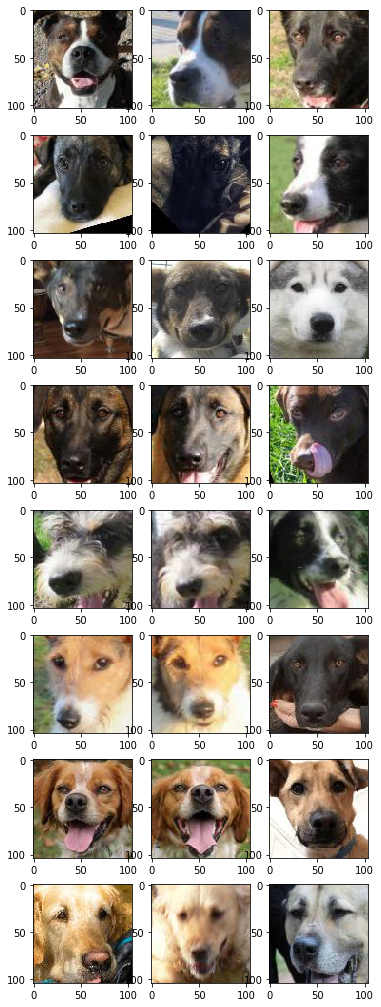

In [10]:
# Test
# Check the triplet
print(y_triplet_train[:24])
plt.figure(figsize=(6,18))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    plt.imshow(triplet_train[i])

In [10]:
# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    #zca_whitening=True
)
train_datagen.fit(images_train[:10])

### Loss definition

In [13]:
alpha = 1.
def cos_triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5

    return tf.nn.relu(ap - an + alpha)

In [8]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

In [13]:
# The following version was found in a blog post
from triplet_loss import batch_all_triplet_loss, batch_hard_triplet_loss
def triplet(y_true,y_pred):
    y_true = y_true[:,0]
    y_true = tf.reshape(y_true,[-1])
#     loss,_ = batch_all_triplet_loss(y_true,y_pred,1.)
    loss = batch_hard_triplet_loss(y_true,y_pred,1.)
    return loss

### Metric definition

In [27]:
def cos_triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5
    
    return K.less(ap,an)

In [9]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Model definition

In [10]:
# dogfacenet_v6
emb_size = 18

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
__________

In [92]:
# dogfacenet_v9
emb_size = 16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 104, 104, 32)      896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 104, 104, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 52, 52, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 26, 26, 128)       0         
__________

In [10]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.10.hard_triplet_trained_2.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [35]:
model.save(PATH_MODEL + '2019.02.10.hard_triplet_trained_2.h5')

In [11]:
#triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [63]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
#new_images_test, new_labels_test = shuffle_classes(images_test,labels_test)

predict_train=model.predict(new_images_train)
#predict_test=model.predict(new_images_test)

new_triplet_train, new_y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

HBox(children=(IntProgress(value=0, max=44), HTML(value='')))

174


HBox(children=(IntProgress(value=0), HTML(value='')))

216


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

234


HBox(children=(IntProgress(value=0), HTML(value='')))

246


HBox(children=(IntProgress(value=0), HTML(value='')))

147


HBox(children=(IntProgress(value=0), HTML(value='')))

267


HBox(children=(IntProgress(value=0), HTML(value='')))

222


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

213


HBox(children=(IntProgress(value=0), HTML(value='')))

171


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

141


HBox(children=(IntProgress(value=0), HTML(value='')))

195


HBox(children=(IntProgress(value=0), HTML(value='')))

408


HBox(children=(IntProgress(value=0), HTML(value='')))

159


HBox(children=(IntProgress(value=0), HTML(value='')))

168


HBox(children=(IntProgress(value=0), HTML(value='')))

201


HBox(children=(IntProgress(value=0), HTML(value='')))

150


HBox(children=(IntProgress(value=0), HTML(value='')))

174


HBox(children=(IntProgress(value=0), HTML(value='')))

321


HBox(children=(IntProgress(value=0), HTML(value='')))

213


HBox(children=(IntProgress(value=0), HTML(value='')))

186


HBox(children=(IntProgress(value=0), HTML(value='')))

168


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

162


HBox(children=(IntProgress(value=0), HTML(value='')))

159


HBox(children=(IntProgress(value=0), HTML(value='')))

222


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

150


HBox(children=(IntProgress(value=0), HTML(value='')))

216


HBox(children=(IntProgress(value=0), HTML(value='')))

138


HBox(children=(IntProgress(value=0), HTML(value='')))

234


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

273


HBox(children=(IntProgress(value=0), HTML(value='')))

171


HBox(children=(IntProgress(value=0), HTML(value='')))

153


HBox(children=(IntProgress(value=0), HTML(value='')))

147


HBox(children=(IntProgress(value=0), HTML(value='')))

207


HBox(children=(IntProgress(value=0), HTML(value='')))

207


HBox(children=(IntProgress(value=0), HTML(value='')))

180


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

99


HBox(children=(IntProgress(value=0), HTML(value='')))

In [67]:
history=model.fit(
    new_triplet_train,
    new_y_triplet_train,
    batch_size = 21*3,
    epochs = 3,
    validation_data=(triplet_test,y_triplet_test),
    shuffle=False
)

Train on 21828 samples, validate on 3000 samples
Epoch 1/3


10647/21828 [=============>................] - ETA: 1:21:37 - loss: 10.4124 - triplet_acc: 0.095 - ETA: 41:36 - loss: 7.7108 - triplet_acc: 0.1190  - ETA: 28:16 - loss: 7.4427 - triplet_acc: 0.11 - ETA: 21:39 - loss: 5.8910 - triplet_acc: 0.27 - ETA: 17:38 - loss: 5.0803 - triplet_acc: 0.35 - ETA: 14:56 - loss: 4.3246 - triplet_acc: 0.43 - ETA: 13:01 - loss: 3.8666 - triplet_acc: 0.45 - ETA: 11:35 - loss: 3.7229 - triplet_acc: 0.47 - ETA: 10:27 - loss: 4.0712 - triplet_acc: 0.43 - ETA: 9:33 - loss: 4.5351 - triplet_acc: 0.4048 - ETA: 8:49 - loss: 4.5592 - triplet_acc: 0.376 - ETA: 8:12 - loss: 4.3819 - triplet_acc: 0.404 - ETA: 7:41 - loss: 4.2392 - triplet_acc: 0.428 - ETA: 7:14 - loss: 4.0727 - triplet_acc: 0.438 - ETA: 6:51 - loss: 3.8614 - triplet_acc: 0.466 - ETA: 6:31 - loss: 3.8666 - triplet_acc: 0.470 - ETA: 6:13 - loss: 4.0605 - triplet_acc: 0.451 - ETA: 5:57 - loss: 4.1240 - triplet_acc: 0.439 - ETA: 5:43 - loss: 4.3422 - triplet_acc: 0.418 - ETA: 5:30 - loss: 4.2307 - triple

21828/21828 [==============================] - ETA: 2s - loss: 2.4685 - triplet_acc: 0.619 - ETA: 1s - loss: 2.4621 - triplet_acc: 0.619 - ETA: 1s - loss: 2.4590 - triplet_acc: 0.620 - ETA: 0s - loss: 2.4540 - triplet_acc: 0.620 - 302s 14ms/step - loss: 2.4533 - triplet_acc: 0.6200 - val_loss: 1.3786 - val_triplet_acc: 0.7640
Epoch 2/3


10710/21828 [=============>................] - ETA: 6:39 - loss: 1.9999 - triplet_acc: 0.619 - ETA: 5:38 - loss: 1.3098 - triplet_acc: 0.761 - ETA: 5:55 - loss: 1.2004 - triplet_acc: 0.730 - ETA: 5:40 - loss: 1.3875 - triplet_acc: 0.714 - ETA: 5:27 - loss: 1.6903 - triplet_acc: 0.695 - ETA: 5:24 - loss: 1.6776 - triplet_acc: 0.698 - ETA: 6:36 - loss: 1.4694 - triplet_acc: 0.714 - ETA: 7:34 - loss: 1.5041 - triplet_acc: 0.702 - ETA: 7:09 - loss: 1.5910 - triplet_acc: 0.677 - ETA: 6:41 - loss: 1.9666 - triplet_acc: 0.642 - ETA: 6:23 - loss: 2.0419 - triplet_acc: 0.623 - ETA: 6:09 - loss: 2.0353 - triplet_acc: 0.631 - ETA: 6:00 - loss: 1.9693 - triplet_acc: 0.644 - ETA: 5:51 - loss: 1.8351 - triplet_acc: 0.663 - ETA: 5:45 - loss: 1.7399 - triplet_acc: 0.673 - ETA: 5:35 - loss: 1.9291 - triplet_acc: 0.669 - ETA: 5:28 - loss: 2.0430 - triplet_acc: 0.658 - ETA: 5:22 - loss: 2.0999 - triplet_acc: 0.648 - ETA: 5:22 - loss: 2.2666 - triplet_acc: 0.641 - ETA: 5:17 - loss: 2.2286 - triplet_acc: 0

21828/21828 [==============================] - ETA: 0s - loss: 2.0117 - triplet_acc: 0.682 - ETA: 0s - loss: 2.0073 - triplet_acc: 0.683 - 255s 12ms/step - loss: 2.0054 - triplet_acc: 0.6832 - val_loss: 1.0769 - val_triplet_acc: 0.8050
Epoch 3/3


10710/21828 [=============>................] - ETA: 6:53 - loss: 1.4055 - triplet_acc: 0.666 - ETA: 5:02 - loss: 1.3853 - triplet_acc: 0.714 - ETA: 7:24 - loss: 1.8152 - triplet_acc: 0.650 - ETA: 6:29 - loss: 1.7706 - triplet_acc: 0.654 - ETA: 5:49 - loss: 1.6337 - triplet_acc: 0.676 - ETA: 5:22 - loss: 1.6375 - triplet_acc: 0.690 - ETA: 5:32 - loss: 1.5092 - triplet_acc: 0.714 - ETA: 5:35 - loss: 1.4872 - triplet_acc: 0.720 - ETA: 5:28 - loss: 1.4155 - triplet_acc: 0.719 - ETA: 5:15 - loss: 1.7380 - triplet_acc: 0.685 - ETA: 4:59 - loss: 1.8159 - triplet_acc: 0.671 - ETA: 4:48 - loss: 1.8171 - triplet_acc: 0.674 - ETA: 4:41 - loss: 1.7121 - triplet_acc: 0.692 - ETA: 4:34 - loss: 1.7278 - triplet_acc: 0.687 - ETA: 4:28 - loss: 1.6788 - triplet_acc: 0.701 - ETA: 4:23 - loss: 1.7487 - triplet_acc: 0.702 - ETA: 4:33 - loss: 1.8203 - triplet_acc: 0.694 - ETA: 4:45 - loss: 1.8992 - triplet_acc: 0.679 - ETA: 4:41 - loss: 1.9584 - triplet_acc: 0.674 - ETA: 4:43 - loss: 1.9373 - triplet_acc: 0

21828/21828 [==============================] - ETA: 0s - loss: 1.7291 - triplet_acc: 0.716 - ETA: 0s - loss: 1.7272 - triplet_acc: 0.716 - 249s 11ms/step - loss: 1.7259 - triplet_acc: 0.7166 - val_loss: 1.1374 - val_triplet_acc: 0.7960


In [ ]:
for i in range(4):

    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    #new_images_test, new_labels_test = shuffle_classes(images_test,labels_test)

    predict_train=model.predict(new_images_train)
    #predict_test=model.predict(new_images_test)

    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)
    #triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 4-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )

HBox(children=(IntProgress(value=0, max=44), HTML(value='')))

192


HBox(children=(IntProgress(value=0), HTML(value='')))

204


HBox(children=(IntProgress(value=0), HTML(value='')))

183


HBox(children=(IntProgress(value=0), HTML(value='')))

186


HBox(children=(IntProgress(value=0), HTML(value='')))

198


HBox(children=(IntProgress(value=0), HTML(value='')))

180


HBox(children=(IntProgress(value=0), HTML(value='')))

186


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

180


HBox(children=(IntProgress(value=0), HTML(value='')))

216


HBox(children=(IntProgress(value=0), HTML(value='')))

162


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

156


HBox(children=(IntProgress(value=0), HTML(value='')))

276


HBox(children=(IntProgress(value=0), HTML(value='')))

180


HBox(children=(IntProgress(value=0), HTML(value='')))

150


HBox(children=(IntProgress(value=0), HTML(value='')))

153


HBox(children=(IntProgress(value=0), HTML(value='')))

186


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

171


HBox(children=(IntProgress(value=0), HTML(value='')))

216


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

207


HBox(children=(IntProgress(value=0), HTML(value='')))

294


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

225


HBox(children=(IntProgress(value=0), HTML(value='')))

288


HBox(children=(IntProgress(value=0), HTML(value='')))

174


HBox(children=(IntProgress(value=0), HTML(value='')))

363


HBox(children=(IntProgress(value=0), HTML(value='')))

147


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

147


HBox(children=(IntProgress(value=0), HTML(value='')))

231


HBox(children=(IntProgress(value=0), HTML(value='')))

141


HBox(children=(IntProgress(value=0), HTML(value='')))

255


HBox(children=(IntProgress(value=0), HTML(value='')))

183


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

204


HBox(children=(IntProgress(value=0), HTML(value='')))

195


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

150


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

126


HBox(children=(IntProgress(value=0), HTML(value='')))


Train on 21828 samples, validate on 3000 samples
Epoch 1/4


10647/21828 [=============>................] - ETA: 20:21 - loss: 7.4656 - triplet_acc: 0.09 - ETA: 11:40 - loss: 6.4786 - triplet_acc: 0.09 - ETA: 8:34 - loss: 5.7908 - triplet_acc: 0.1905 - ETA: 9:01 - loss: 4.6196 - triplet_acc: 0.357 - ETA: 10:56 - loss: 3.7730 - triplet_acc: 0.45 - ETA: 13:13 - loss: 3.5546 - triplet_acc: 0.50 - ETA: 14:13 - loss: 3.3168 - triplet_acc: 0.55 - ETA: 14:49 - loss: 3.1801 - triplet_acc: 0.57 - ETA: 14:07 - loss: 3.5123 - triplet_acc: 0.52 - ETA: 13:31 - loss: 3.7706 - triplet_acc: 0.48 - ETA: 13:27 - loss: 3.9507 - triplet_acc: 0.46 - ETA: 13:08 - loss: 3.7262 - triplet_acc: 0.48 - ETA: 13:00 - loss: 3.5332 - triplet_acc: 0.50 - ETA: 12:58 - loss: 3.3894 - triplet_acc: 0.52 - ETA: 12:17 - loss: 3.2070 - triplet_acc: 0.54 - ETA: 11:35 - loss: 3.1093 - triplet_acc: 0.55 - ETA: 11:00 - loss: 3.2033 - triplet_acc: 0.53 - ETA: 10:32 - loss: 3.5619 - triplet_acc: 0.51 - ETA: 10:07 - loss: 3.5122 - triplet_acc: 0.51 - ETA: 9:44 - loss: 3.3873 - triplet_acc: 

10710/21828 [=============>................] - ETA: 12:42 - loss: 4.6941 - triplet_acc: 0.42 - ETA: 11:20 - loss: 3.3001 - triplet_acc: 0.50 - ETA: 10:32 - loss: 3.1187 - triplet_acc: 0.52 - ETA: 10:42 - loss: 2.5846 - triplet_acc: 0.58 - ETA: 10:40 - loss: 2.2237 - triplet_acc: 0.60 - ETA: 10:28 - loss: 1.9032 - triplet_acc: 0.64 - ETA: 10:30 - loss: 1.7011 - triplet_acc: 0.68 - ETA: 9:57 - loss: 1.6534 - triplet_acc: 0.6845 - ETA: 9:43 - loss: 1.7863 - triplet_acc: 0.645 - ETA: 9:36 - loss: 1.9691 - triplet_acc: 0.604 - ETA: 9:29 - loss: 2.0233 - triplet_acc: 0.593 - ETA: 9:24 - loss: 1.9476 - triplet_acc: 0.603 - ETA: 8:50 - loss: 1.8530 - triplet_acc: 0.622 - ETA: 8:24 - loss: 1.8198 - triplet_acc: 0.642 - ETA: 7:59 - loss: 1.7169 - triplet_acc: 0.660 - ETA: 7:36 - loss: 1.6862 - triplet_acc: 0.672 - ETA: 7:15 - loss: 1.8300 - triplet_acc: 0.655 - ETA: 6:58 - loss: 2.1449 - triplet_acc: 0.634 - ETA: 6:45 - loss: 2.1521 - triplet_acc: 0.626 - ETA: 6:30 - loss: 2.0986 - triplet_acc: 

21828/21828 [==============================] - ETA: 3s - loss: 2.1525 - triplet_acc: 0.653 - ETA: 2s - loss: 2.1493 - triplet_acc: 0.653 - ETA: 1s - loss: 2.1433 - triplet_acc: 0.654 - ETA: 0s - loss: 2.1376 - triplet_acc: 0.655 - 351s 16ms/step - loss: 2.1349 - triplet_acc: 0.6556 - val_loss: 1.4106 - val_triplet_acc: 0.7820
Epoch 3/4


10710/21828 [=============>................] - ETA: 5:04 - loss: 4.1122 - triplet_acc: 0.523 - ETA: 4:38 - loss: 3.2655 - triplet_acc: 0.571 - ETA: 4:36 - loss: 3.1724 - triplet_acc: 0.587 - ETA: 4:54 - loss: 2.5752 - triplet_acc: 0.654 - ETA: 6:27 - loss: 2.2839 - triplet_acc: 0.685 - ETA: 7:46 - loss: 2.2757 - triplet_acc: 0.698 - ETA: 7:44 - loss: 2.0307 - triplet_acc: 0.714 - ETA: 7:11 - loss: 1.8885 - triplet_acc: 0.726 - ETA: 6:45 - loss: 1.8966 - triplet_acc: 0.709 - ETA: 6:41 - loss: 2.0842 - triplet_acc: 0.676 - ETA: 6:36 - loss: 2.1443 - triplet_acc: 0.666 - ETA: 6:42 - loss: 2.0505 - triplet_acc: 0.678 - ETA: 6:49 - loss: 1.9280 - triplet_acc: 0.688 - ETA: 6:47 - loss: 1.8669 - triplet_acc: 0.697 - ETA: 6:41 - loss: 1.8074 - triplet_acc: 0.698 - ETA: 6:31 - loss: 1.7557 - triplet_acc: 0.708 - ETA: 6:24 - loss: 1.7566 - triplet_acc: 0.691 - ETA: 6:29 - loss: 2.1766 - triplet_acc: 0.658 - ETA: 6:38 - loss: 2.1214 - triplet_acc: 0.664 - ETA: 6:47 - loss: 2.0380 - triplet_acc: 0

10710/21828 [=============>................] - ETA: 6:27 - loss: 3.1896 - triplet_acc: 0.523 - ETA: 5:30 - loss: 3.6154 - triplet_acc: 0.500 - ETA: 6:29 - loss: 2.6637 - triplet_acc: 0.571 - ETA: 7:11 - loss: 2.0683 - triplet_acc: 0.631 - ETA: 6:40 - loss: 2.0868 - triplet_acc: 0.647 - ETA: 6:11 - loss: 1.8659 - triplet_acc: 0.674 - ETA: 5:59 - loss: 1.7890 - triplet_acc: 0.687 - ETA: 6:03 - loss: 1.6162 - triplet_acc: 0.708 - ETA: 5:58 - loss: 1.9331 - triplet_acc: 0.677 - ETA: 5:49 - loss: 1.9039 - triplet_acc: 0.676 - ETA: 5:51 - loss: 1.8308 - triplet_acc: 0.688 - ETA: 6:20 - loss: 1.7825 - triplet_acc: 0.698 - ETA: 6:42 - loss: 1.7322 - triplet_acc: 0.699 - ETA: 6:58 - loss: 1.6599 - triplet_acc: 0.704 - ETA: 7:14 - loss: 1.6042 - triplet_acc: 0.714 - ETA: 7:17 - loss: 1.5223 - triplet_acc: 0.729 - ETA: 7:12 - loss: 1.5345 - triplet_acc: 0.725 - ETA: 8:01 - loss: 1.8443 - triplet_acc: 0.701 - ETA: 8:47 - loss: 1.8350 - triplet_acc: 0.701 - ETA: 8:31 - loss: 1.7919 - triplet_acc: 0

21828/21828 [==============================] - ETA: 2s - loss: 1.5797 - triplet_acc: 0.739 - ETA: 1s - loss: 1.5789 - triplet_acc: 0.740 - ETA: 0s - loss: 1.5744 - triplet_acc: 0.740 - 349s 16ms/step - loss: 1.5722 - triplet_acc: 0.7411 - val_loss: 1.4614 - val_triplet_acc: 0.8040


HBox(children=(IntProgress(value=0, max=44), HTML(value='')))

252


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

249


HBox(children=(IntProgress(value=0), HTML(value='')))

291


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

156


HBox(children=(IntProgress(value=0), HTML(value='')))

225


HBox(children=(IntProgress(value=0), HTML(value='')))

249


HBox(children=(IntProgress(value=0), HTML(value='')))

177


HBox(children=(IntProgress(value=0), HTML(value='')))

216


HBox(children=(IntProgress(value=0), HTML(value='')))

186


HBox(children=(IntProgress(value=0), HTML(value='')))

192


HBox(children=(IntProgress(value=0), HTML(value='')))

291


HBox(children=(IntProgress(value=0), HTML(value='')))

156


HBox(children=(IntProgress(value=0), HTML(value='')))

129


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

174


HBox(children=(IntProgress(value=0), HTML(value='')))

171


HBox(children=(IntProgress(value=0), HTML(value='')))

189


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

165


HBox(children=(IntProgress(value=0), HTML(value='')))

153


HBox(children=(IntProgress(value=0), HTML(value='')))

237


HBox(children=(IntProgress(value=0), HTML(value='')))

192


HBox(children=(IntProgress(value=0), HTML(value='')))

177


HBox(children=(IntProgress(value=0), HTML(value='')))

255


HBox(children=(IntProgress(value=0), HTML(value='')))

183


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

162


HBox(children=(IntProgress(value=0), HTML(value='')))

258


HBox(children=(IntProgress(value=0), HTML(value='')))

252


HBox(children=(IntProgress(value=0), HTML(value='')))

210


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

168


HBox(children=(IntProgress(value=0), HTML(value='')))

183


HBox(children=(IntProgress(value=0), HTML(value='')))

183


HBox(children=(IntProgress(value=0), HTML(value='')))

159


HBox(children=(IntProgress(value=0), HTML(value='')))

129


HBox(children=(IntProgress(value=0), HTML(value='')))

219


HBox(children=(IntProgress(value=0), HTML(value='')))

159


HBox(children=(IntProgress(value=0), HTML(value='')))

168


HBox(children=(IntProgress(value=0), HTML(value='')))

96


HBox(children=(IntProgress(value=0), HTML(value='')))


Train on 21828 samples, validate on 3000 samples
Epoch 1/3
 4725/21828 [=====>........................] - ETA: 52:09 - loss: 7.8413 - triplet_acc: 0.25 - ETA: 40:03 - loss: 8.2788 - triplet_acc: 0.19 - ETA: 32:18 - loss: 7.0744 - triplet_acc: 0.28 - ETA: 27:07 - loss: 6.0541 - triplet_acc: 0.36 - ETA: 23:33 - loss: 5.4092 - triplet_acc: 0.40 - ETA: 20:45 - loss: 4.8278 - triplet_acc: 0.45 - ETA: 18:37 - loss: 4.6094 - triplet_acc: 0.47 - ETA: 17:01 - loss: 5.0507 - triplet_acc: 0.44 - ETA: 15:40 - loss: 5.0851 - triplet_acc: 0.41 - ETA: 14:26 - loss: 4.8265 - triplet_acc: 0.43 - ETA: 13:25 - loss: 4.5354 - triplet_acc: 0.46 - ETA: 12:32 - loss: 4.3044 - triplet_acc: 0.48 - ETA: 11:53 - loss: 4.1129 - triplet_acc: 0.51 - ETA: 11:22 - loss: 3.9351 - triplet_acc: 0.52 - ETA: 10:46 - loss: 3.7313 - triplet_acc: 0.54 - ETA: 10:20 - loss: 3.9420 - triplet_acc: 0.53 - ETA: 9:51 - loss: 4.0483 - triplet_acc: 0.5263 - ETA: 9:25 - loss: 4.4134 - triplet_acc: 0.500 - ETA: 9:12 - loss: 4.3916 - t

In [65]:
# Test on new triplet integrity
print(new_y_triplet_train[-30:])
t = np.equal(new_y_triplet_train[0::3],new_y_triplet_train[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

[277. 277. 216. 279. 279. 344.  70.  70. 459. 460. 460. 174. 155. 155.
 104. 427. 427. 235.  89.  89. 274. 458. 458. 397. 454. 454. 484.  81.
  81. 237.]
[ True  True  True ...  True  True  True]


1.0

In [13]:
def shuffle_classes(images,labels):
    """
    Shuffles the classes
    """
    classes = np.unique(labels)
    np.random.shuffle(classes)
    
    shuffled_images = np.empty(images.shape)
    shuffled_labels = np.empty(labels.shape)
    idx = 0
    for i in range(len(classes)):
        keep_classes = np.equal(labels,classes[i])
        length = np.sum(keep_classes.astype(int))
        shuffled_labels[idx:idx+length] = labels[keep_classes]
        shuffled_images[idx:idx+length] = images[keep_classes]
        idx += length
    return shuffled_images, shuffled_labels

In [57]:
def global_define_hard_triplets(images,labels,predict):
    """
    Generates hard triplet for offline selection. It will consider the whole dataset.
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    nbof_classes = len(classes)
    triplets = np.empty((3*len(predict),h,w,c))
    y_triplets = np.empty(3*len(predict))
    
    idx_triplets = 0
    idx_images = 0
    
    for i in range(nbof_classes):
        keep_class = np.equal(labels,classes[i])
        mask_class = np.identity(len(predict)) * keep_class.astype(np.float32)
        
        #predict_class = mask_class.dot(predict)
        predict_other = np.copy(predict)
        for j in range(len(predict)):
            if keep_class[j]:
                predict_other[j] += np.inf
        
        keep_predict_class = predict[keep_class]
        
        for j in range(len(keep_predict_class)):
            # Computes the distance between the current vector and the vectors in the class
            dist_class = np.sum(np.square(keep_predict_class-keep_predict_class[j]),axis=-1)
            
            # Add the anchor
            triplets[idx_triplets] = images[idx_images+j]
            y_triplets[idx_triplets] = labels[idx_images+j]
            
            # Add the hard positive
            triplets[idx_triplets+1] = images[idx_images+np.argmax(dist_class)]
            y_triplets[idx_triplets+1] = labels[idx_images+np.argmax(dist_class)]
            
            # Computes the distance between the current vector and the vectors of the others classes
            dist_other = np.sum(np.square(predict_other-keep_predict_class[j]),axis=-1)
            
            # Add the hard negative
            triplets[idx_triplets+2] = images[np.argmin(dist_other)]
            y_triplets[idx_triplets+2] = labels[np.argmin(dist_other)]
            
            idx_triplets += 3
        
        idx_images += len(keep_predict_class)
        
    return triplets, y_triplets

In [62]:
# Offline triplet selection:
# Generate hard triplets

def define_hard_triplets(images,labels,predict,class_subset_size=10, add=100*3):
    """
    Generates hard triplet for offline selection
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
        -class_subset_class: number of classes in a subset
        -
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    nbof_classes = len(classes)
    triplets = np.empty((3*len(predict)+add*(nbof_classes//class_subset_size + 1),h,w,c))
    y_triplets = np.empty(3*len(predict)+add*(nbof_classes//class_subset_size + 1))
    idx = 0
    for i in tqdm_notebook(range(0,len(classes),class_subset_size)):
        selected_classes = classes[i:i+class_subset_size]
        keep_classes = np.array([labels[j] in selected_classes for j in range(len(labels))])
        
        selected_predict = predict[keep_classes]
        length = len(selected_predict)*3
        
        triplets_tmp,y_triplets_tmp = global_define_hard_triplets(
                                                                images[keep_classes],
                                                                labels[keep_classes],
                                                                selected_predict
                                                            )
        print(len(triplets_tmp))
        
        triplets[idx:idx+length] = triplets_tmp
        y_triplets[idx:idx+length] = y_triplets_tmp
        
        triplets[idx+length:idx+length+add], y_triplets[idx+length:idx+length+add] = define_triplets(images, labels, add)
        
        idx += len(triplets_tmp) + add
    return triplets, y_triplets

In [60]:
lez = 30
n_images_train, n_labels_train = shuffle_classes(images_train[:lez],labels_train[:lez])

# Test
predict = model.predict(n_images_train)
# Takes a subset of classes:
_,idx_classes = np.unique(n_labels_train,return_index=True)
classes = n_labels_train[idx_classes]

# step1
selected_classes = classes[0:10]
keep_classes = np.array([n_labels_train[i] in selected_classes for i in range(len(n_labels_train))])

selected_predict = predict[keep_classes]
length = len(selected_predict)

im,lab1 = global_define_hard_triplets(n_images_train[keep_classes],n_labels_train[keep_classes],selected_predict)

In [53]:
n_labels_train

array([52., 52., 52., 52., 52., 51., 51., 51., 51., 51., 51., 51., 53.,
       53., 48., 48., 48., 48., 48., 50., 50., 50., 50., 50., 50., 49.,
       49., 49., 49., 49.])

In [44]:
len(im)

165

In [45]:
len(predict[keep_classes])

55

In [41]:
t

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [61]:
print(lab1[-30:])
t = np.equal(lab1[0::3],lab1[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

[52. 52. 51. 52. 52. 51. 53. 53. 50. 53. 53. 50. 50. 50. 51. 50. 50. 48.
 50. 50. 48. 50. 50. 51. 50. 50. 53. 50. 50. 49.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


1.0

In [93]:
histories = []
n = 4
for i in range(n):
    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 24*3,
        epochs = n-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]
    triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
    triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)
    

Train on 30000 samples, validate on 3000 samples
Epoch 1/4
30000/30000 [==============================] - 119s 4ms/step - loss: 7.0979 - triplet_acc: 0.0571 - val_loss: 4.0956 - val_triplet_acc: 0.3310
Epoch 2/4
30000/30000 [==============================] - 114s 4ms/step - loss: 4.0997 - triplet_acc: 0.4458 - val_loss: 2.5808 - val_triplet_acc: 0.5920
Epoch 3/4
30000/30000 [==============================] - 112s 4ms/step - loss: 2.7597 - triplet_acc: 0.6173 - val_loss: 2.0851 - val_triplet_acc: 0.6410
Epoch 4/4
30000/30000 [==============================] - 113s 4ms/step - loss: 2.1827 - triplet_acc: 0.6947 - val_loss: 1.7840 - val_triplet_acc: 0.7570



Train on 30000 samples, validate on 3000 samples
Epoch 1/3
30000/30000 [==============================] - 112s 4ms/step - loss: 1.9124 - triplet_acc: 0.7291 - val_loss: 1.4763 - val_triplet_acc: 0.7420
Epoch 2/3
30000/30000 [==============================] - 113s 4ms/step - loss: 1.6028 - triplet_acc: 0.7688 - val_loss: 1.6551 - val_triplet_acc: 0.7710
Epoch 3/3
30000/30000 [==============================] - 112s 4ms/step - loss: 1.3242 - triplet_acc: 0.8070 - val_loss: 1.4604 - val_triplet_acc: 0.8150



Train on 30000 samples, validate on 3000 samples
Epoch 1/2
30000/30000 [==============================] - 113s 4ms/step - loss: 1.4515 - triplet_acc: 0.7978 - val_loss: 1.0689 - val_triplet_acc: 0.8290
Epoch 2/2
30000/30000 [==============================] - 112s 4ms/step - loss: 1.2557 - triplet_acc: 0.8194 - val_loss: 1.0898 - val_triplet_acc: 0.8280



Train on 30000 samples, validate on 3000 samples
Epoch 1/1
30000/30000 [==============================] - 113s 4ms/step - loss: 1.2575 - triplet_acc: 0.8183 - val_loss: 0.8215 - val_triplet_acc: 0.8310


In [95]:
model.save(PATH_MODEL+'2019.02.08.dogfacenet_v9.emb_16.h5')

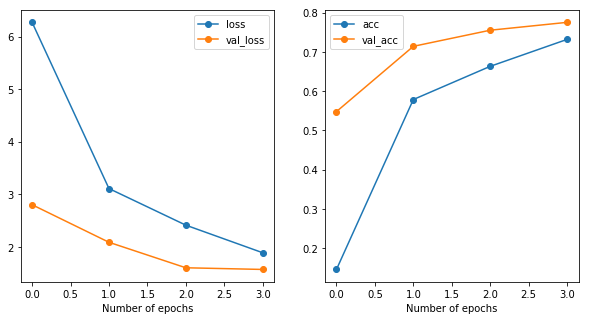

In [75]:
history = histories[0]
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['triplet_acc']
val_acc = history.history['val_triplet_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
# np.save(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.npy',history_)
# np.savetxt(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

### Evaluate it

#### Evaluate on verification task

In [76]:
# Create pairs
h,w,c = SIZE
pairs = np.empty((len(images_test)*2,h,w,c))
issame = np.empty(len(images_test))
class_test = np.unique(labels_test)
for i in range(len(images_test)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

[1. 0. 0. 1. 1.]


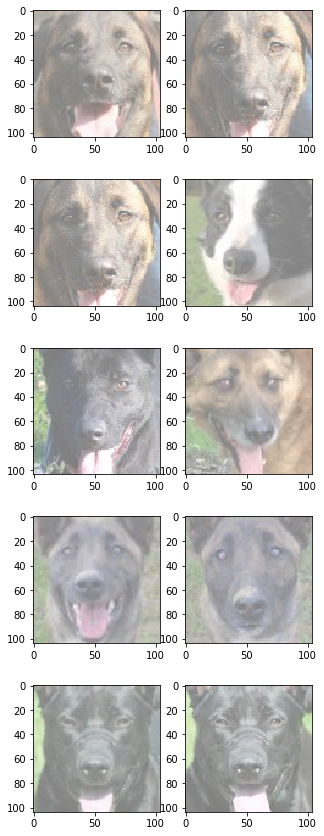

In [31]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [96]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Compute the angle between pairs

best = 0
best_t = 0
thresholds = np.arange(0.0001,4,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

Best threshold: 0.4871
Best accuracy: 0.9093959731543624


### Face clustering

In [97]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [98]:
len(labels_test)

298

In [99]:
from sklearn.cluster import KMeans

In [100]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)), random_state=0,tol=1e-6).fit(predict)

In [101]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

[0. 0. 0. 0. 0. 0.]


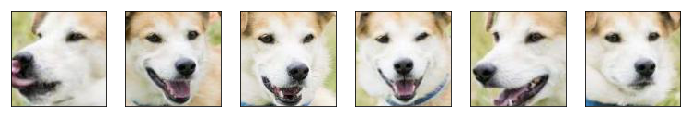

[ 9. 13. 19. 19. 19. 19. 19. 27. 27. 31. 31.]


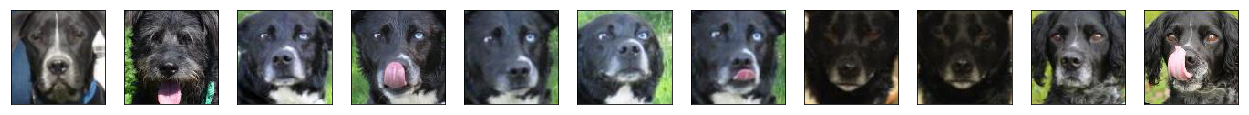

[16. 16. 16.]


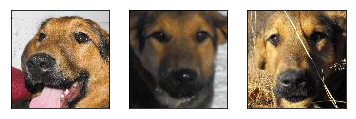

[21. 21. 21. 21. 21. 37.]


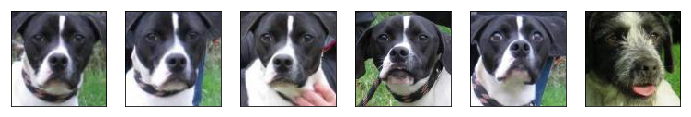

[13. 28. 28. 28. 28. 28. 28. 28. 28. 28. 36.]


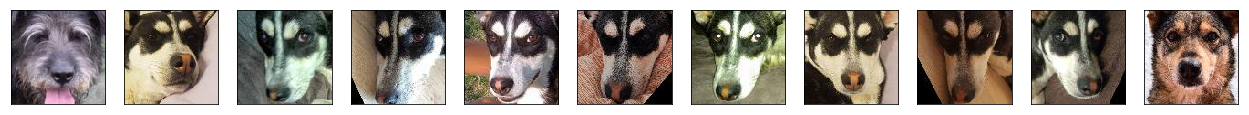

[ 8. 16. 25. 34. 34. 41. 41. 41. 41. 46. 46. 46.]


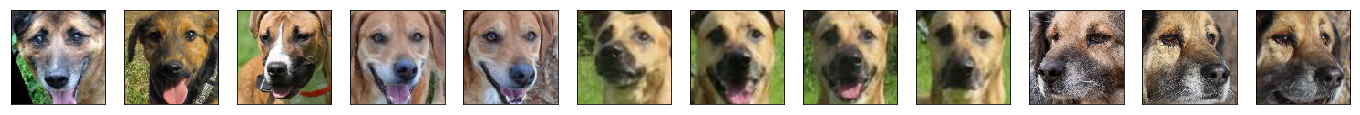

[ 3.  7.  7. 11. 11. 11.]


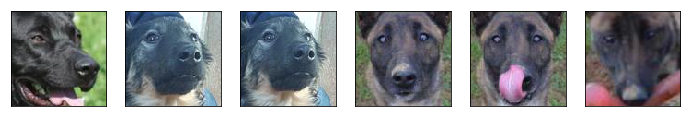

[17. 17. 17. 17. 18. 18.]


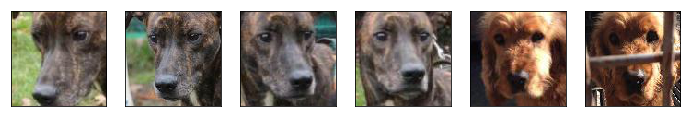

[16. 35. 44. 44. 44. 47. 47.]


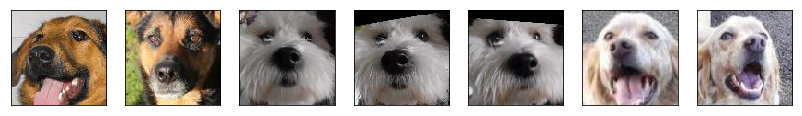

[12. 12. 23. 30. 30. 30. 30. 30.]


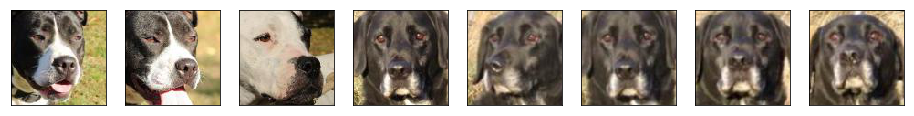

[22. 22. 23. 23. 40. 40. 40. 40. 40. 40. 40. 47.]


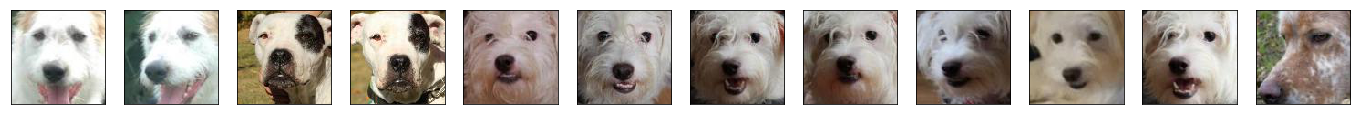

[16. 32. 35. 35. 35. 35.]


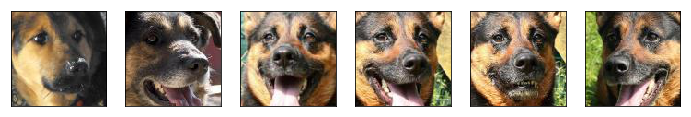

[ 5. 29. 42.]


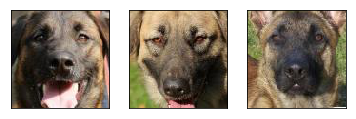

[ 7.  7.  7. 10. 13. 13.]


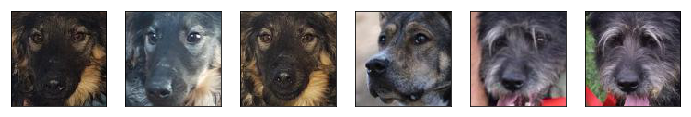

[16. 16. 16. 16. 16. 36.]


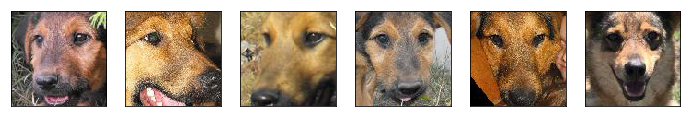

[24. 24. 24. 24. 24. 26. 26. 26. 26. 26.]


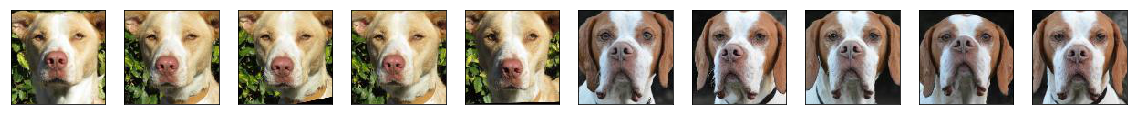

[44. 44. 44. 44.]


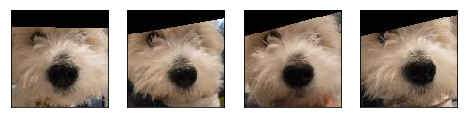

[16. 16. 16. 32. 32. 32.]


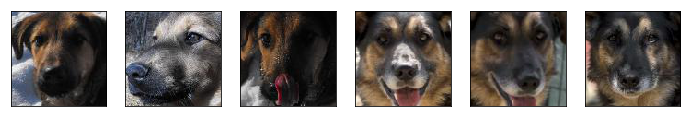

[ 9.  9.  9. 12. 12. 12.]


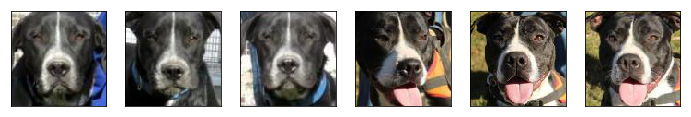

[ 1.  1.  1. 12. 13.]


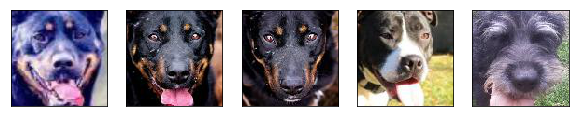

[18. 18. 18. 18. 38.]


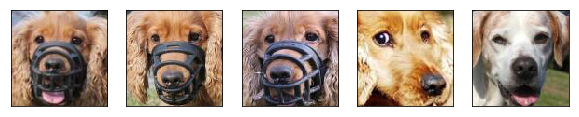

[22. 22. 22. 22. 40.]


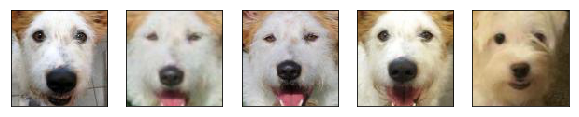

[16. 16. 16. 35. 35. 35.]


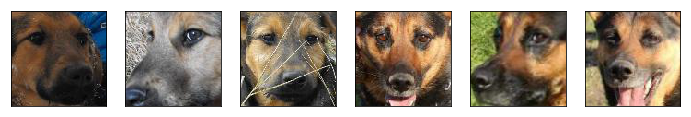

[29. 29. 29. 29. 29.]


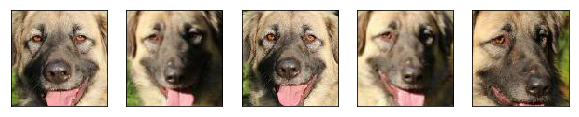

In [102]:
for i in range(24):
    length = len(images_cluster[i])
    print(labels_cluster[i])
    plt.figure(figsize=(length*2,2))
    for j in range(length):
        plt.subplot(1,length,j+1)
        plt.imshow(images_cluster[i][j])
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Recognition

In [103]:
s = 30.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [104]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [105]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [106]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(len(labels_test_exp[0]))(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [109]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=5)

Epoch 1/5
298/298 [==============================] - 0s 1ms/step - loss: 532.7815 - acc: 0.5638
Epoch 2/5
298/298 [==============================] - 0s 1ms/step - loss: 526.4888 - acc: 0.5671
Epoch 3/5
298/298 [==============================] - 0s 1ms/step - loss: 525.2254 - acc: 0.6107
Epoch 4/5
298/298 [==============================] - 0s 1ms/step - loss: 521.5208 - acc: 0.5403
Epoch 5/5
298/298 [==============================] - 0s 1ms/step - loss: 519.5541 - acc: 0.6007


### Observation on the heatmap

In [91]:
model.layers

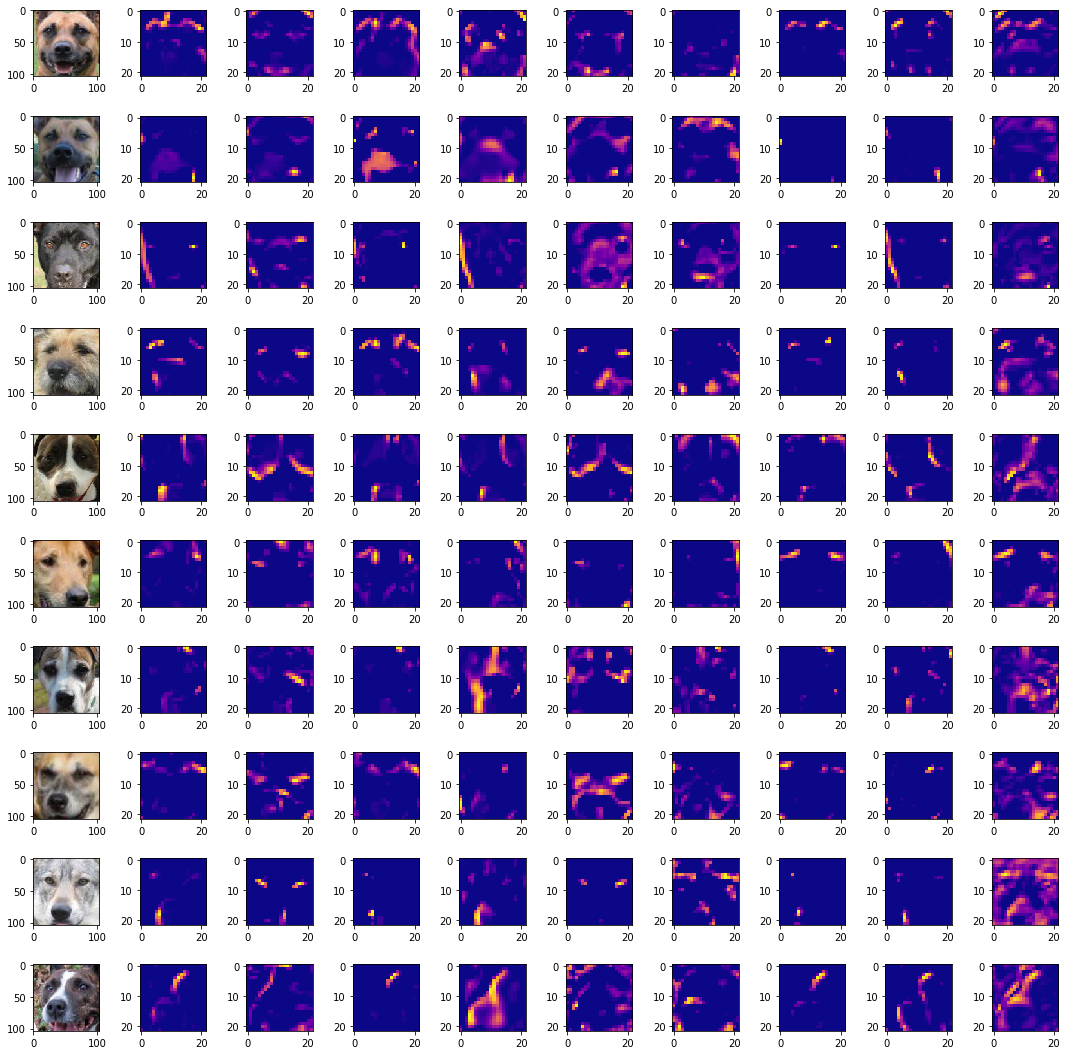

In [24]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[7].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

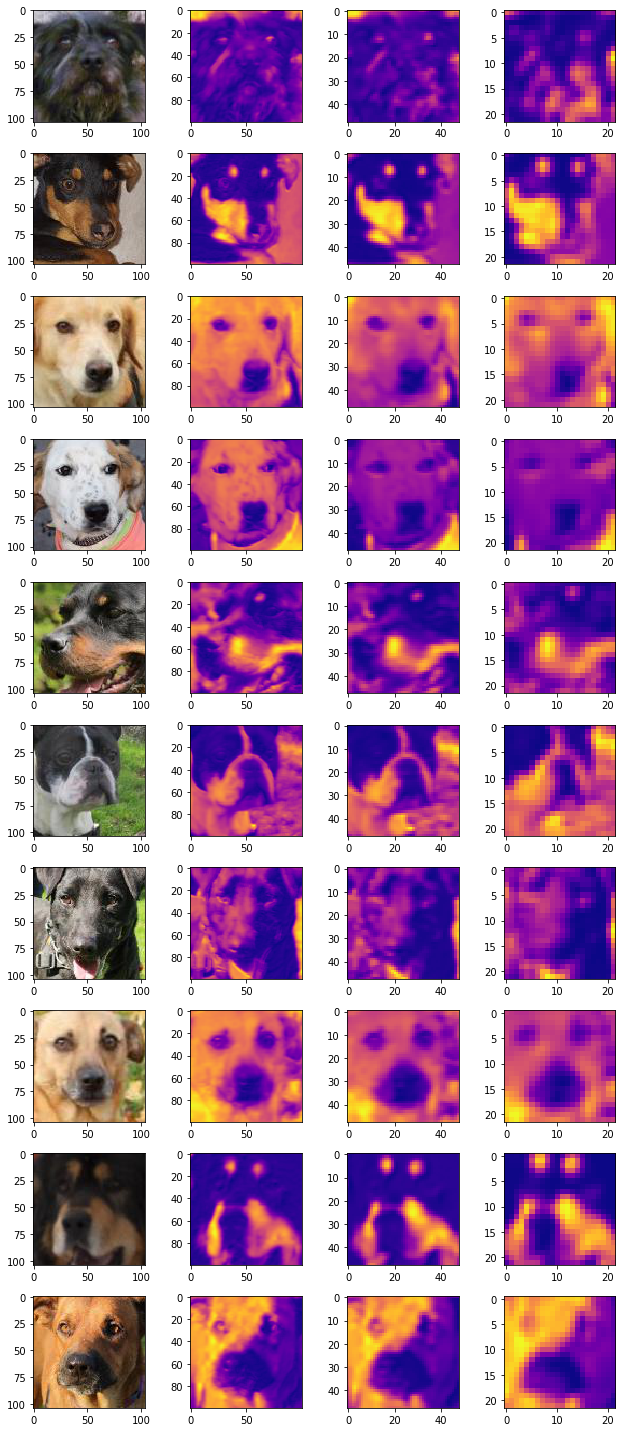

In [90]:
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0:100:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[4].output)
predict2 = mod2.predict(images_train[0:100:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[7].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

### Archives:

In [12]:
# dogfacenet_v7
out_num = len(unique)

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Lambda

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(104, 104, 3))
x = base_model.output
# x = base_model.layers[8].output
# x = MaxPooling2D((2,2))(x)
# x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(18)(x)
x = Lambda(lambda x: tf.math.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104, 104, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 104, 104, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 104, 104, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 52, 52, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 52, 52, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 52, 52, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 26, 26, 128)       0         
__________

In [17]:
triplet_train_pre = tf.keras.applications.vgg16.preprocess_input(triplet_train)

In [21]:
history=model.fit(
    triplet_train_pre,
    np.zeros((len(triplet_train),18)),
    batch_size = 63,
    epochs = 100,
    validation_split=0.1
)

Train on 27000 samples, validate on 3000 samples
Epoch 1/100
27000/27000 [==============================] - 75s 3ms/step - loss: 6.2989 - triplet_acc: 0.5084 - val_loss: 6.2688 - val_triplet_acc: 0.6670
Epoch 2/100
27000/27000 [==============================] - 74s 3ms/step - loss: 6.2962 - triplet_acc: 0.5050 - val_loss: 6.2688 - val_triplet_acc: 0.6750
Epoch 3/100
27000/27000 [==============================] - 74s 3ms/step - loss: 6.2955 - triplet_acc: 0.4880 - val_loss: 6.2688 - val_triplet_acc: 0.6810
Epoch 4/100
27000/27000 [==============================] - 75s 3ms/step - loss: 6.2901 - triplet_acc: 0.4918 - val_loss: 6.2689 - val_triplet_acc: 0.6990
Epoch 5/100
 3591/27000 [==>...........................] - ETA: 1:26 - loss: 6.3122 - triplet_acc: 0.4971

KeyboardInterrupt: 

In [31]:
# dogfacenet_v8 : inspired from FaceNet paper
emb_size = 64

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(64, (5, 5), strides=(2,2), activation='relu', input_shape=(104, 104, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x)))

model.compile(loss=triplet,
              optimizer='adagrad',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 50, 50, 64)        4864      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 25, 25, 64)        4160      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 25, 25, 192)       110784    
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 192)       768       
__________

In [13]:
# dogfacenet_v4
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Cosine(out_num))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 102, 102, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 256)       147712    
_________________________________________________________________
activation_1 (Activation)    (None, 49, 49, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 512)       1180160   
__________

In [14]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/12
40/40 [==============================] - ETA: 6:40 - loss: 3033.9841 - acc: 0.0000e+ - ETA: 3:20 - loss: 3193.7477 - acc: 0.0078   - ETA: 2:14 - loss: 3131.7262 - acc: 0.00 - ETA: 1:41 - loss: 3100.9213 - acc: 0.00 - ETA: 1:21 - loss: 3011.6771 - acc: 0.01 - ETA: 1:07 - loss: 2969.4160 - acc: 0.01 - ETA: 57s - loss: 2898.0631 - acc: 0.0089 - ETA: 50s - loss: 2821.5505 - acc: 0.007 - ETA: 44s - loss: 2773.2350 - acc: 0.006 - ETA: 39s - loss: 2718.2655 - acc: 0.006 - ETA: 35s - loss: 2673.9746 - acc: 0.005 - ETA: 32s - loss: 2639.0772 - acc: 0.005 - ETA: 29s - loss: 2607.5262 - acc: 0.004 - ETA: 27s - loss: 2588.1751 - acc: 0.004 - ETA: 24s - loss: 2556.4133 - acc: 0.004 - ETA: 22s - loss: 2525.0515 - acc: 0.004 - ETA: 21s - loss: 2379.7240 - acc: 0.004 - ETA: 19s - loss: 2365.8392 - acc: 0.004 - ETA: 18s - loss: 2358.0670 - acc: 0.004 - ETA: 16s - loss: 2344.6071 - acc: 0.004 - ETA: 15s - loss: 2334.9984 - acc: 0.004 - ETA: 14s - loss: 2315.3236 - acc: 0.004 - ETA: 13s - loss

40/40 [==============================] - ETA: 12s - loss: 1553.2555 - acc: 0.046 - ETA: 11s - loss: 1557.4442 - acc: 0.023 - ETA: 11s - loss: 1559.9218 - acc: 0.020 - ETA: 11s - loss: 1564.8853 - acc: 0.019 - ETA: 11s - loss: 1560.9692 - acc: 0.021 - ETA: 10s - loss: 1562.4371 - acc: 0.020 - ETA: 10s - loss: 1563.6058 - acc: 0.017 - ETA: 10s - loss: 1563.6732 - acc: 0.019 - ETA: 9s - loss: 1562.8299 - acc: 0.019 - ETA: 9s - loss: 1560.2613 - acc: 0.02 - ETA: 9s - loss: 1559.2021 - acc: 0.02 - ETA: 9s - loss: 1559.6456 - acc: 0.02 - ETA: 8s - loss: 1559.8105 - acc: 0.02 - ETA: 8s - loss: 1562.1020 - acc: 0.02 - ETA: 8s - loss: 1564.2353 - acc: 0.02 - ETA: 7s - loss: 1473.9175 - acc: 0.01 - ETA: 6s - loss: 1479.2918 - acc: 0.01 - ETA: 6s - loss: 1484.0584 - acc: 0.01 - ETA: 6s - loss: 1487.1040 - acc: 0.01 - ETA: 5s - loss: 1490.0914 - acc: 0.02 - ETA: 5s - loss: 1493.1654 - acc: 0.02 - ETA: 5s - loss: 1496.8550 - acc: 0.02 - ETA: 5s - loss: 1499.7177 - acc: 0.02 - ETA: 4s - loss: 1503.3

In [41]:
model.save('../output/model/dogfacenet_v6_cosine.h5')

### Train it

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-5),
              metrics=['accuracy'])

In [18]:
model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 50,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/50


c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/13 [==============================] - ETA: 1:29 - loss: 4.8474 - acc: 0.0000e+0 - ETA: 41s - loss: 4.8427 - acc: 0.0156    - ETA: 25s - loss: 4.8440 - acc: 0.01 - ETA: 17s - loss: 4.8413 - acc: 0.01 - ETA: 12s - loss: 4.8375 - acc: 0.01 - ETA: 9s - loss: 4.8348 - acc: 0.0140 - ETA: 6s - loss: 4.8315 - acc: 0.016 - ETA: 5s - loss: 4.8274 - acc: 0.014 - ETA: 3s - loss: 4.8269 - acc: 0.018 - ETA: 2s - loss: 4.8270 - acc: 0.020 - ETA: 1s - loss: 4.8270 - acc: 0.021 - ETA: 0s - loss: 4.8276 - acc: 0.021 - 9s 674ms/step - loss: 4.8283 - acc: 0.0221 - val_loss: 4.8029 - val_acc: 0.0290
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 4.7678 - acc: 0.062 - ETA: 0s - loss: 4.7703 - acc: 0.039 - ETA: 0s - loss: 4.7796 - acc: 0.031 - ETA: 1s - loss: 4.7835 - acc: 0.027 - ETA: 0s - loss: 4.7769 - acc: 0.031 - ETA: 0s - loss: 4.7819 - acc: 0.026 - ETA: 0s - loss: 4.7791 - acc: 0.026 - ETA: 0s - loss: 4.7824 - acc: 0.027 - ETA: 0s - loss: 4.7803 - acc: 0.024 - ETA: 0s - loss: 4

Epoch 15/50
13/13 [==============================] - ETA: 1s - loss: 4.5012 - acc: 0.125 - ETA: 1s - loss: 4.4540 - acc: 0.125 - ETA: 1s - loss: 4.4515 - acc: 0.125 - ETA: 1s - loss: 4.4257 - acc: 0.148 - ETA: 1s - loss: 4.4377 - acc: 0.140 - ETA: 1s - loss: 4.4397 - acc: 0.140 - ETA: 0s - loss: 4.4405 - acc: 0.147 - ETA: 0s - loss: 4.4501 - acc: 0.144 - ETA: 0s - loss: 4.4489 - acc: 0.147 - ETA: 0s - loss: 4.4454 - acc: 0.150 - ETA: 0s - loss: 4.4487 - acc: 0.149 - ETA: 0s - loss: 4.4516 - acc: 0.145 - 2s 172ms/step - loss: 4.4499 - acc: 0.1480 - val_loss: 4.3780 - val_acc: 0.1594
Epoch 16/50
13/13 [==============================] - ETA: 2s - loss: 4.4242 - acc: 0.156 - ETA: 2s - loss: 4.4119 - acc: 0.156 - ETA: 1s - loss: 4.4161 - acc: 0.166 - ETA: 1s - loss: 4.4338 - acc: 0.164 - ETA: 1s - loss: 4.4340 - acc: 0.175 - ETA: 1s - loss: 4.4467 - acc: 0.161 - ETA: 1s - loss: 4.4539 - acc: 0.151 - ETA: 1s - loss: 4.4572 - acc: 0.152 - ETA: 0s - loss: 4.4554 - acc: 0.152 - ETA: 0s - loss: 

KeyboardInterrupt: 

In [49]:
model.save('../output/model/small_net_2.h5')